## Probability Calibration

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

In this notebook, we will re-calibrate probabilities utilizing a balanced dataset for the demo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.filterwarnings("ignore")

## Load balanced dataset

In [2]:
# load cancer dataset

X, y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(X)
X['target'] = y
X['target'] = X['target'].map({0: 1, 1: 0})

X.shape

(569, 31)

In [3]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X.drop(labels=['target'], axis=1),  # drop the target
    X['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [4]:
# balancing ratio

y_train.value_counts() / len(X_train)

target
0    0.625628
1    0.374372
Name: count, dtype: float64

The target is not exactly balanced, but not super imbalanced either.

In [5]:
# number of observations per class

y_train.value_counts()

target
0    249
1    149
Name: count, dtype: int64

## Naive Bayes

In [6]:
# Train Naive Bayes
bayes = GaussianNB().fit(X_train, y_train)

# score the test set
probs = bayes.predict_proba(X_test)[:, 1]

In [7]:
print('roc-auc on train set: ', roc_auc_score(y_train, bayes.predict_proba(X_train)[:, 1]))
print('roc-auc on test set: ', roc_auc_score(y_test, probs))

roc-auc on train set:  0.9893803401525565
roc-auc on test set:  0.9854497354497355


In [8]:
print('Brier Score on train set: ', brier_score_loss(y_train, bayes.predict_proba(X_train)[:, 1]))
print('Brier Score on test set: ', brier_score_loss(y_test, probs))

Brier Score on train set:  0.051000734589839634
Brier Score on test set:  0.07586880889698376


## Calibration Curve

In [9]:
def plot_calibration_curve(y_true, probs, bins, strategy):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy=strategy)
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label='Naive Bayes')
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=True, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

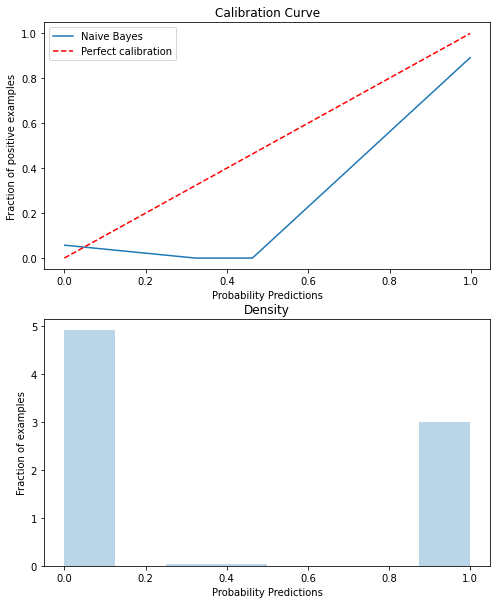

In [10]:
plot_calibration_curve(y_test, probs, bins=8, strategy='uniform')

## Probability Re-calibration

In [11]:
# Isotonic calibration

clf_isotonic = CalibratedClassifierCV(bayes, cv=5, method='isotonic')
clf_isotonic.fit(X_test, y_test)
prob_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Sigmoid calibration

clf_sigmoid = CalibratedClassifierCV(bayes, cv=5, method='sigmoid')
clf_sigmoid.fit(X_test, y_test)
prob_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

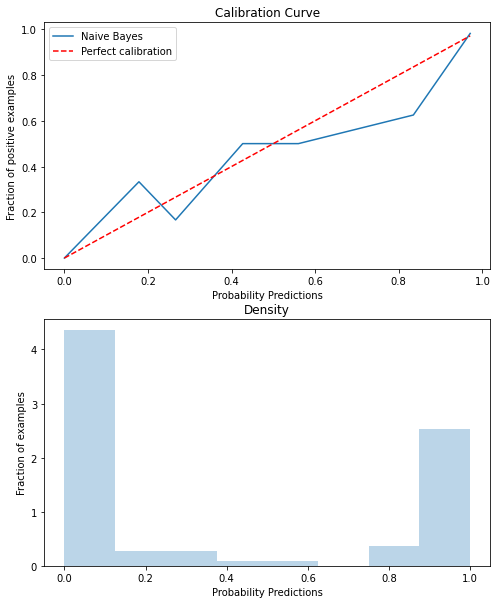

In [12]:
plot_calibration_curve(y_test, prob_isotonic, bins=8, strategy='uniform')

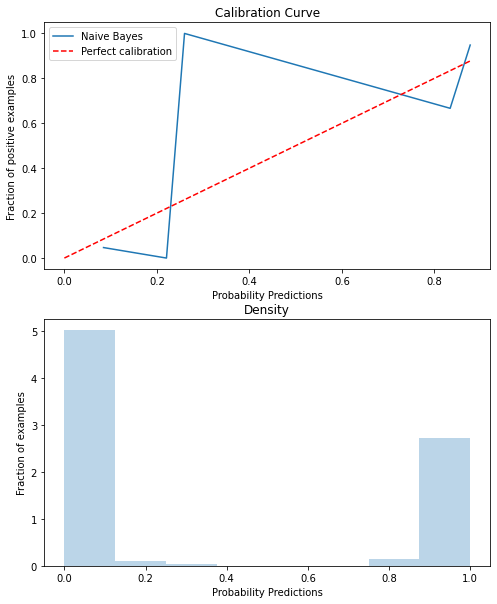

In [13]:
plot_calibration_curve(y_test, prob_sigmoid, bins=8, strategy='uniform')

The Isotonic Calibration worked better than Plat Scaling

**HOMEWORK**

Why don't you try and assess if the probability of the models you train for your own projects are calibrated? and if they are not, try and calibrate them with one of this methods.